In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
from gensim import corpora, models, similarities

In [65]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [7]:
logging.basicConfig(format='%(asctime)s : %(Levlname)s : %(message)s', level=logging.INFO)

In [2]:
# load pickled data
pkls = !ls pkl/itunes*.pkl
pkl_dfs = [pd.DataFrame(pd.read_pickle(pkl)) for pkl in pkls]
podcastDf = pd.concat(pkl_dfs[0:2])

In [4]:
podcastDf.shape

(4676, 16)

In [13]:
documents = podcastDf['itunes_summary']

In [16]:
# remove common words and tokenize
stoplist = set('for a of the and to in'.split())
texts = [[word for word in document.lower().split() if word not in stoplist] for document in documents]

# remove words that appear only once
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]

In [17]:
from pprint import pprint
pprint(texts)

[['we', 'chat', 'about', 'movies,', 'tv', 'stuff'],
 ['florence',
  'bailey',
  'was',
  'an',
  'american',
  'nature',
  'writer.',
  'she',
  'started',
  'observing',
  'bird',
  'behavior',
  'at',
  'time',
  'when',
  'most',
  'bird',
  'study',
  'was',
  'based',
  'on',
  'by',
  '1885,',
  'she',
  'began',
  'write',
  'articles',
  'focusing',
  'on',
  'protecting',
  'her',
  'introduction',
  'field',
  'guide,',
  'aimed',
  'at',
  'living',
  'is',
  'considered',
  'first',
  'tradition',
  'modern',
  'bird',
  'she',
  'wrote',
  'first',
  'these',
  'at',
  'age',
  'initially',
  'as',
  'series',
  'notes',
  'magazine',
  'later',
  'as',
  'books.',
  'on',
  'she',
  'writes',
  'an',
  'engaging',
  'memoir',
  'about',
  'her',
  'several',
  'study',
  'birds',
  'on',
  'ranch',
  'california',
  'late',
  "1800's."],
 ['one',
  'hour',
  'radio',
  'show',
  'that',
  'plays',
  'bluegrass,',
  'old',
  'time',
  'gospel',
  'music',
  'only',
  'by',

In [18]:
dictionary = corpora.Dictionary(texts)
dictionary.save('tmp.dict')
print(dictionary)

Dictionary(8058 unique tokens: [u'writings', u'<description', u'hordes', u'remixes,', u'four']...)


In [19]:
print(dictionary.token2id)

{u'writings': 3386, u'<description': 6426, u'hordes': 7986, u'remixes,': 865, u'four': 1872, u'woods': 3263, u'it&#039;s': 2002, u"friend's": 7781, u'preface': 2902, u'downloads.': 7352, u'lord': 938, u'regional': 5477, u'advice.': 4869, u'advice,': 2027, u'hdtv': 4248, u'bringing': 634, u'writing.': 5456, u'<itunes:author>phil': 1661, u'recollections': 6930, u'scholar': 4179, u'wednesday': 1576, u'straight': 1311, u'annie': 3111, u'charter': 4952, u'her.': 4690, u'her,': 6368, u'miller': 1561, u'funny.': 5974, u'pulse': 6151, u'knight-errantry': 5238, u'second': 410, u'consciousness,': 2695, u'journalism,': 4235, u'nature,': 5685, u'nature.': 6062, u'cooking': 104, u'understood.': 3424, u'designing': 6761, u'replaced': 6845, u'increasing': 4727, u'pioneering': 6477, u'grace.': 1924, u'hero': 6950, u'common?': 7284, u'herb': 5303, u'here': 863, u'lgbt': 3860, u'china': 3636, u'cult': 5185, u'affiliated': 7983, u'conversational': 1777, u'kids': 2549, u'uplifting': 1551, u'elaborate': 14

In [20]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('tmp.mm', corpus)

In [21]:
tfidf = models.TfidfModel(corpus)

In [22]:
corpus_tfidf = tfidf[corpus]

In [25]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=10)
corpus_lsi = lsi[corpus_tfidf]

In [27]:
index = similarities.MatrixSimilarity(lsi[corpus])

In [39]:
doc = podcastDf.iloc[400]['itunes_summary']
doc

'Sermons from the morning worship services of Adamsville Baptist Church'

In [40]:
vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi[vec_bow]

In [54]:
sims = index[vec_lsi]

In [55]:
sims = sorted(enumerate(sims), key=lambda item: -item[1])
top_10_sims = sims[1:11]

In [56]:
top_10_sims

[(4205, 0.99975049),
 (4671, 0.99969363),
 (4669, 0.99966842),
 (4663, 0.99965203),
 (4524, 0.99961603),
 (3798, 0.99957681),
 (4655, 0.99957234),
 (1822, 0.99956208),
 (2438, 0.99956191),
 (3185, 0.99952775)]

In [52]:
podcastDf.iloc[4205]['itunes_summary']

'Sermons from Beaumont Bible Church'

In [63]:
print 'Test Text:', doc
for sim in top_10_sims:
    print sim[1], podcastDf.iloc[sim[0]]['itunes_summary']

Test Text: Sermons from the morning worship services of Adamsville Baptist Church
0.99975 Sermons from Beaumont Bible Church
0.999694 Watch the sermons from Bethel Church in Richland, WA
0.999668 Sunday Sermons from Bethel Church in North Platte, NE
0.999652 Sermons from Bethel Church
0.999616 Sermons from Berean Baptist Church
0.999577 Sermons from Banchory East Church
0.999572 Sermons from Bethel Baptist Church
0.999562 Sermons from Angel of Joy Lutheran Church (ELCA) in Lufkin, TX.
0.999562 Sermons from Arlington Community Church
0.999528 Sermons from Austin Mennonite Church


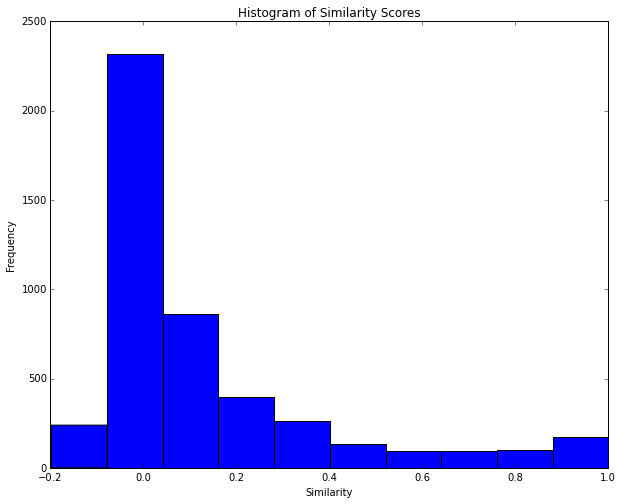

In [73]:
sim_scores = [sim[1] for sim in sims]
plt.hist(sim_scores)
plt.title('Histogram of Similarity Scores')
plt.xlabel('Similarity')
plt.ylabel('Frequency')